In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import mlflow

np.set_printoptions(precision=3, suppress=True)
tf.__version__

'2.4.1'

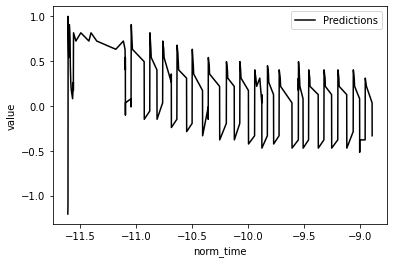

In [2]:
# Read dataset from file
raw_dataset = pd.read_csv("./data_grouped/1161114004_122_.csv")
raw_dataset = raw_dataset.astype({'id':'float','value':'float', 'station_id':'int', 'parameter_id':'int', 'unix_timestamp':'int', 'norm_time':'float'})
dataset = raw_dataset.copy()
dataset = dataset.dropna().drop(['id','station_id','parameter_id','unix_timestamp'], axis=1)
dataset_full = dataset.sort_values(by=['norm_time'])
dataset = dataset_full[0:300]

plt.plot(dataset['norm_time'], dataset['norm_value'], color='k', label='Predictions')
plt.xlabel('norm_time')
plt.ylabel('value')
plt.legend()
plt.show()

In [3]:
test_file_name = "./data_grouped/1161114002_122_.csv"
test_raw_dataset = pd.read_csv(test_file_name)
test_raw_dataset = test_raw_dataset.astype({'id':'float','value':'float', 'station_id':'int', 'parameter_id':'int', 'unix_timestamp':'int', 'norm_time':'float'})
test_dataset = test_raw_dataset.copy()
test_dataset = test_dataset.dropna().drop(['id','station_id','parameter_id','unix_timestamp'], axis=1)
test_dataset_full = test_dataset.sort_values(by=['norm_time'])
start_line = 0
end_line = 44
test_data = test_dataset_full[start_line:end_line]

In [4]:
serial_data = dataset.drop(['value','norm_time'], axis=1)
serial_data['norm_1'] = serial_data['norm_value'].shift(1)
serial_data['norm_2'] = serial_data['norm_value'].shift(2)
serial_data['norm_3'] = serial_data['norm_value'].shift(3)
serial_data['norm_4'] = serial_data['norm_value'].shift(4)
serial_data['norm_5'] = serial_data['norm_value'].shift(5)
serial_data['norm_6'] = serial_data['norm_value'].shift(6)
serial_data = serial_data[6:]
serial_data

,norm_value,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,0.311370,0.632730,-0.055900,-0.423169,-0.790439,-1.111800,-1.203617
7,1.000000,0.311370,0.632730,-0.055900,-0.423169,-0.790439,-1.111800
8,0.908183,1.000000,0.311370,0.632730,-0.055900,-0.423169,-0.790439
9,0.816365,0.908183,1.000000,0.311370,0.632730,-0.055900,-0.423169
10,0.724548,0.816365,0.908183,1.000000,0.311370,0.632730,-0.055900
...,...,...,...,...,...,...,...
295,0.219552,0.311370,-0.009991,0.127735,-0.147717,-0.285443,-0.377261
296,0.035917,0.219552,0.311370,-0.009991,0.127735,-0.147717,-0.285443
297,-0.055900,0.035917,0.219552,0.311370,-0.009991,0.127735,-0.147717
298,-0.193626,-0.055900,0.035917,0.219552,0.311370,-0.009991,0.127735


In [5]:
test_serial_data = test_data.drop(['value','norm_time'], axis=1)
test_serial_data['norm_1'] = test_serial_data['norm_value'].shift(1)
test_serial_data['norm_2'] = test_serial_data['norm_value'].shift(2)
test_serial_data['norm_3'] = test_serial_data['norm_value'].shift(3)
test_serial_data['norm_4'] = test_serial_data['norm_value'].shift(4)
test_serial_data['norm_5'] = test_serial_data['norm_value'].shift(5)
test_serial_data['norm_6'] = test_serial_data['norm_value'].shift(6)
test_serial_data = test_serial_data[6:]
test_serial_data

,norm_value,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597,-0.311759
7,-0.118853,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597
8,-0.196016,-0.118853,-0.003110,0.074052,-0.003110,-0.080272,-0.157435
9,-0.273178,-0.196016,-0.118853,-0.003110,0.074052,-0.003110,-0.080272
10,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110,0.074052,-0.003110
11,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110,0.074052
12,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110
13,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853
14,-0.157435,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016
15,-0.080272,-0.157435,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178


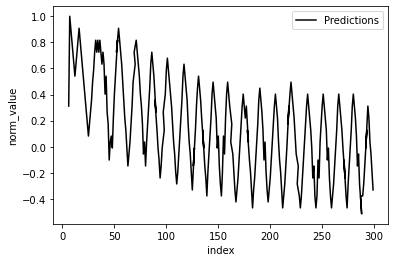

In [6]:
plt.plot(serial_data.index, serial_data['norm_value'], color='k', label='Predictions')
plt.xlabel('index')
plt.ylabel('norm_value')
plt.legend()
plt.show()

In [7]:
train_dataset = serial_data
test_dataset = test_serial_data

In [8]:
train_features = np.array(train_dataset.drop(['norm_value'], axis=1))
train_features = np.array(train_features)[:,:,np.newaxis]
train_features.shape

(294, 6, 1)

In [9]:
train_labels = np.array(train_dataset.drop(['norm_6'], axis=1))
train_labels = train_labels.reshape(train_labels.shape[0],train_labels.shape[1],1)
train_labels.shape

(294, 6, 1)

In [10]:
# train_labels

In [11]:
test_features = np.array(test_dataset.drop(['norm_value'], axis=1))
test_features = test_features.reshape(test_features.shape[0],test_features.shape[1],1)
test_features.shape

(38, 6, 1)

In [12]:
test_dataset.drop(['norm_value'], axis=1)

,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,0.074052,-0.003110,-0.080272,-0.157435,-0.234597,-0.311759
7,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597
8,-0.118853,-0.003110,0.074052,-0.003110,-0.080272,-0.157435
9,-0.196016,-0.118853,-0.003110,0.074052,-0.003110,-0.080272
10,-0.273178,-0.196016,-0.118853,-0.003110,0.074052,-0.003110
11,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110,0.074052
12,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110
13,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853
14,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016
15,-0.157435,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178


In [13]:
np.array(test_dataset.drop(['norm_value'], axis=1))

array([[ 0.074, -0.003, -0.08 , -0.157, -0.235, -0.312],
       [-0.003,  0.074, -0.003, -0.08 , -0.157, -0.235],
       [-0.119, -0.003,  0.074, -0.003, -0.08 , -0.157],
       [-0.196, -0.119, -0.003,  0.074, -0.003, -0.08 ],
       [-0.273, -0.196, -0.119, -0.003,  0.074, -0.003],
       [-0.35 , -0.273, -0.196, -0.119, -0.003,  0.074],
       [-0.428, -0.35 , -0.273, -0.196, -0.119, -0.003],
       [-0.312, -0.428, -0.35 , -0.273, -0.196, -0.119],
       [-0.235, -0.312, -0.428, -0.35 , -0.273, -0.196],
       [-0.157, -0.235, -0.312, -0.428, -0.35 , -0.273],
       [-0.08 , -0.157, -0.235, -0.312, -0.428, -0.35 ],
       [-0.003, -0.08 , -0.157, -0.235, -0.312, -0.428],
       [ 0.074, -0.003, -0.08 , -0.157, -0.235, -0.312],
       [-0.003,  0.074, -0.003, -0.08 , -0.157, -0.235],
       [-0.08 , -0.003,  0.074, -0.003, -0.08 , -0.157],
       [-0.157, -0.08 , -0.003,  0.074, -0.003, -0.08 ],
       [-0.235, -0.157, -0.08 , -0.003,  0.074, -0.003],
       [-0.312, -0.235, -0.157,

In [14]:
test_labels = np.array(test_dataset.drop(['norm_6'], axis=1))
test_labels = test_labels.reshape(test_labels.shape[0],test_labels.shape[1],1)
test_labels.shape

(38, 6, 1)

In [17]:
model = keras.Sequential()
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.005))
model.fit(train_features, train_labels, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
294/294 - 11s - loss: 0.0193
Epoch 2/100
294/294 - 2s - loss: 0.0097
Epoch 3/100
294/294 - 1s - loss: 0.0090
Epoch 4/100
294/294 - 2s - loss: 0.0058
Epoch 5/100
294/294 - 1s - loss: 0.0050
Epoch 6/100
294/294 - 1s - loss: 0.0047
Epoch 7/100
294/294 - 2s - loss: 0.0043
Epoch 8/100
294/294 - 3s - loss: 0.0047
Epoch 9/100
294/294 - 3s - loss: 0.0048
Epoch 10/100
294/294 - 3s - loss: 0.0044
Epoch 11/100
294/294 - 3s - loss: 0.0057
Epoch 12/100
294/294 - 2s - loss: 0.0046
Epoch 13/100
294/294 - 2s - loss: 0.0045
Epoch 14/100
294/294 - 2s - loss: 0.0042
Epoch 15/100
294/294 - 1s - loss: 0.0046
Epoch 16/100
294/294 - 1s - loss: 0.0049
Epoch 17/100
294/294 - 1s - loss: 0.0048
Epoch 18/100
294/294 - 1s - loss: 0.0046
Epoch 19/100
294/294 - 1s - loss: 0.0042
Epoch 20/100
294/294 - 1s - loss: 0.0045
Epoch 21/100
294/294 - 1s - loss: 0.0043
Epoch 22/100
294/294 - 1s - loss: 0.0044
Epoch 23/100
294/294 - 1s - loss: 0.0045
Epoch 24/100
294/294 - 2s - loss: 0.0045
Epoch 25/100
294/294 - 2

In [18]:
model.save("BTS_LSTM_model")

INFO:tensorflow:Assets written to: BTS_LSTM_model/assets


INFO:tensorflow:Assets written to: BTS_LSTM_model/assets


           0         1         2         3         4         5
0   0.075359  0.035977 -0.026748 -0.093229 -0.160322 -0.228761
1   0.015347  0.037775  0.030360 -0.011884 -0.075064 -0.147353
2  -0.069800 -0.064609  0.007311  0.032361  0.001628 -0.061907
3  -0.123306 -0.169158 -0.094751 -0.000591  0.032742  0.006421
4  -0.174221 -0.251713 -0.195888 -0.095335 -0.008106  0.026246
5  -0.222580 -0.333676 -0.280047 -0.185268 -0.099601 -0.021954
6  -0.268431 -0.414733 -0.364286 -0.260311 -0.184406 -0.114263
7  -0.198717 -0.389377 -0.418564 -0.342724 -0.262352 -0.198363
8  -0.149085 -0.290563 -0.376331 -0.384086 -0.337242 -0.274615
9  -0.096878 -0.209335 -0.277660 -0.340004 -0.367081 -0.341593
10 -0.042070 -0.127646 -0.193793 -0.250982 -0.321229 -0.362192
11  0.015347 -0.045783 -0.110085 -0.172665 -0.236554 -0.313263
12  0.075359  0.035977 -0.026748 -0.093229 -0.160322 -0.228761
13  0.015347  0.037775  0.030360 -0.011884 -0.075064 -0.147353
14 -0.042070 -0.044900  0.012962  0.032246  0.000527 -0

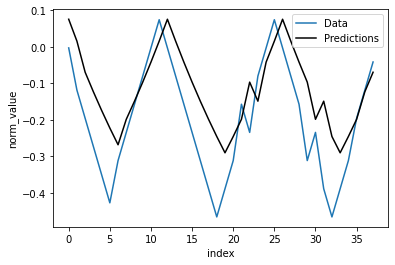

In [16]:

from sklearn.metrics import mean_squared_error

with mlflow.start_run():

    result = model.predict(test_features, batch_size=1, verbose=0)
    # print(result)
    x=pd.DataFrame(test_labels.reshape(test_labels.shape[0],test_labels.shape[1]))
    y=pd.DataFrame(result.reshape(result.shape[0],result.shape[1]))
    y_true = np.array(x[0])
    y_pred = np.array(y[0])

    print(y, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print("MSE", mse)
    
    mlflow.log_metric("MSE",mse)
    mlflow.log_param("test line from ", '{} {}'.format(start_line, end_line))
    mlflow.log_param("Test file", test_file_name)
    plt.plot(x.index, x[0], label='Data')
    plt.plot(y.index, y[0], color='k', label='Predictions')
    plt.xlabel('index')
    plt.ylabel('norm_value')
    plt.legend()
    plt.savefig("BTS_resultGraph.png")
    mlflow.log_artifact("BTS_resultGraph.png")
    plt.show()
    plt.close()

In [34]:
# => data line 200 den 250 lech => 800 den 850
# 950-1150

In [21]:
input = [
    [0.074], [-0.003], [-0.08], [-0.157], [-0.235], [-0.312]
]
input_data = np.array(input, dtype=np.float32)
print(input_data.reshape(1,6,1))

[[[ 0.074]
  [-0.003]
  [-0.08 ]
  [-0.157]
  [-0.235]
  [-0.312]]]
